In [1]:
import pandas as pd
import numpy as np
from timeit import default_timer as timer
pd.options.plotting.backend = 'plotly'

In [2]:
train = pd.read_csv('train.csv')
states = train['Province_State'].unique()
state_dfs_raw = {state: train[train['Province_State'] == state] for state in states}
state_means = {}
state_stds = {}
state_dfs = {}
for s, state_df_raw in state_dfs_raw.items():
    state_df = state_df_raw.drop(columns=['Province_State', 'ID'])
    state_df['Date'] = pd.to_datetime(state_df['Date'], format='%m-%d-%Y')
    state_df = state_df.set_index('Date')

    mean, std = state_df.mean(), state_df.std()
    state_df = (state_df - mean) / std

    state_means[s] = mean
    state_stds[s] = std
    state_dfs[s] = state_df

column_names = state_dfs['Alabama'].columns

In [3]:
from CustomModels import RidgeAR

lag_order = 15
n_features = column_names.size

def model_factory():
    model = RidgeAR(lag_order)
    return model

In [4]:
# Normally takes 80s to train
models = {}
model_histories = {}
model_test_data = {}
for state in states:
    stime = timer()
    print(f'------------------------\nTraining model for {state}')
    state_data = np.nan_to_num(state_dfs[state].values)
    state_data = np.diff(state_data, 1, axis=0)

    model = model_factory()
    res = model.fit(state_data)
    models[state] = model

    print(f'\tTraining took {timer() - stime:.4f}s')

------------------------
Training model for Alabama
	Training took 0.0241s
------------------------
Training model for Alaska
	Training took 0.0048s
------------------------
Training model for Arizona
	Training took 0.0065s
------------------------
Training model for Arkansas
	Training took 0.0080s
------------------------
Training model for California
	Training took 0.0068s
------------------------
Training model for Colorado
	Training took 0.0056s
------------------------
Training model for Connecticut
	Training took 0.0045s
------------------------
Training model for Delaware
	Training took 0.0055s
------------------------
Training model for Florida
	Training took 0.0047s
------------------------
Training model for Georgia
	Training took 0.0053s
------------------------
Training model for Hawaii
	Training took 0.0057s
------------------------
Training model for Idaho
	Training took 0.0046s
------------------------
Training model for Illinois
	Training took 0.0054s
------------------

In [5]:
def forecast(model, data, steps, columns, index):
    output = []
    for _ in range(steps):
        prediction = model.predict(data)
        output.append(prediction)
        data = np.vstack((data[1:], prediction))

    return pd.DataFrame(output, columns=columns, index=index)

In [6]:
state_forecasts = {}
periods = 26
columns, index = column_names, pd.date_range(state_dfs['Alabama'].index[-1], periods=periods + 1)[1:]
for state in states:
    print(f'Forecasting {state} ({index[0]} to {index[-1]})')
    data_df = state_dfs[state].iloc[-lag_order - 1:]

    forecast_df = forecast(models[state], np.diff(np.nan_to_num(data_df.values), axis=0), periods, columns, index)
    state_forecasts[state] = forecast_df.cumsum() + data_df.iloc[-1]

Forecasting Alabama (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Alaska (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Arizona (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Arkansas (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting California (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Colorado (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Connecticut (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Delaware (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Florida (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Georgia (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Hawaii (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Idaho (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Illinois (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Indiana (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Iowa (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Kansas (2

In [7]:
cleaned_dfs = {}
for state in states:
    cleaned_df = state_forecasts[state][['Confirmed', 'Deaths']]
    cleaned_df['Province_State'] = state
    cleaned_df['Date'] = cleaned_df.index

    cleaned_df['Confirmed'] *= state_stds[state]['Confirmed']
    cleaned_df['Deaths'] *= state_stds[state]['Deaths']
    cleaned_df['Confirmed'] += state_means[state]['Confirmed']
    cleaned_df['Deaths'] += state_means[state]['Deaths']


    cleaned_dfs[state] = cleaned_df[['Province_State', 'Date', 'Confirmed', 'Deaths']]

kaggle_res = []

for _ in range(periods):
    for state in states:
        kaggle_res.append(cleaned_dfs[state].iloc[_])

kaggle_res = pd.DataFrame(kaggle_res).reset_index(drop=True)[['Confirmed', 'Deaths']].astype('int')
kaggle_res.index.rename('ForecastID', inplace=True)

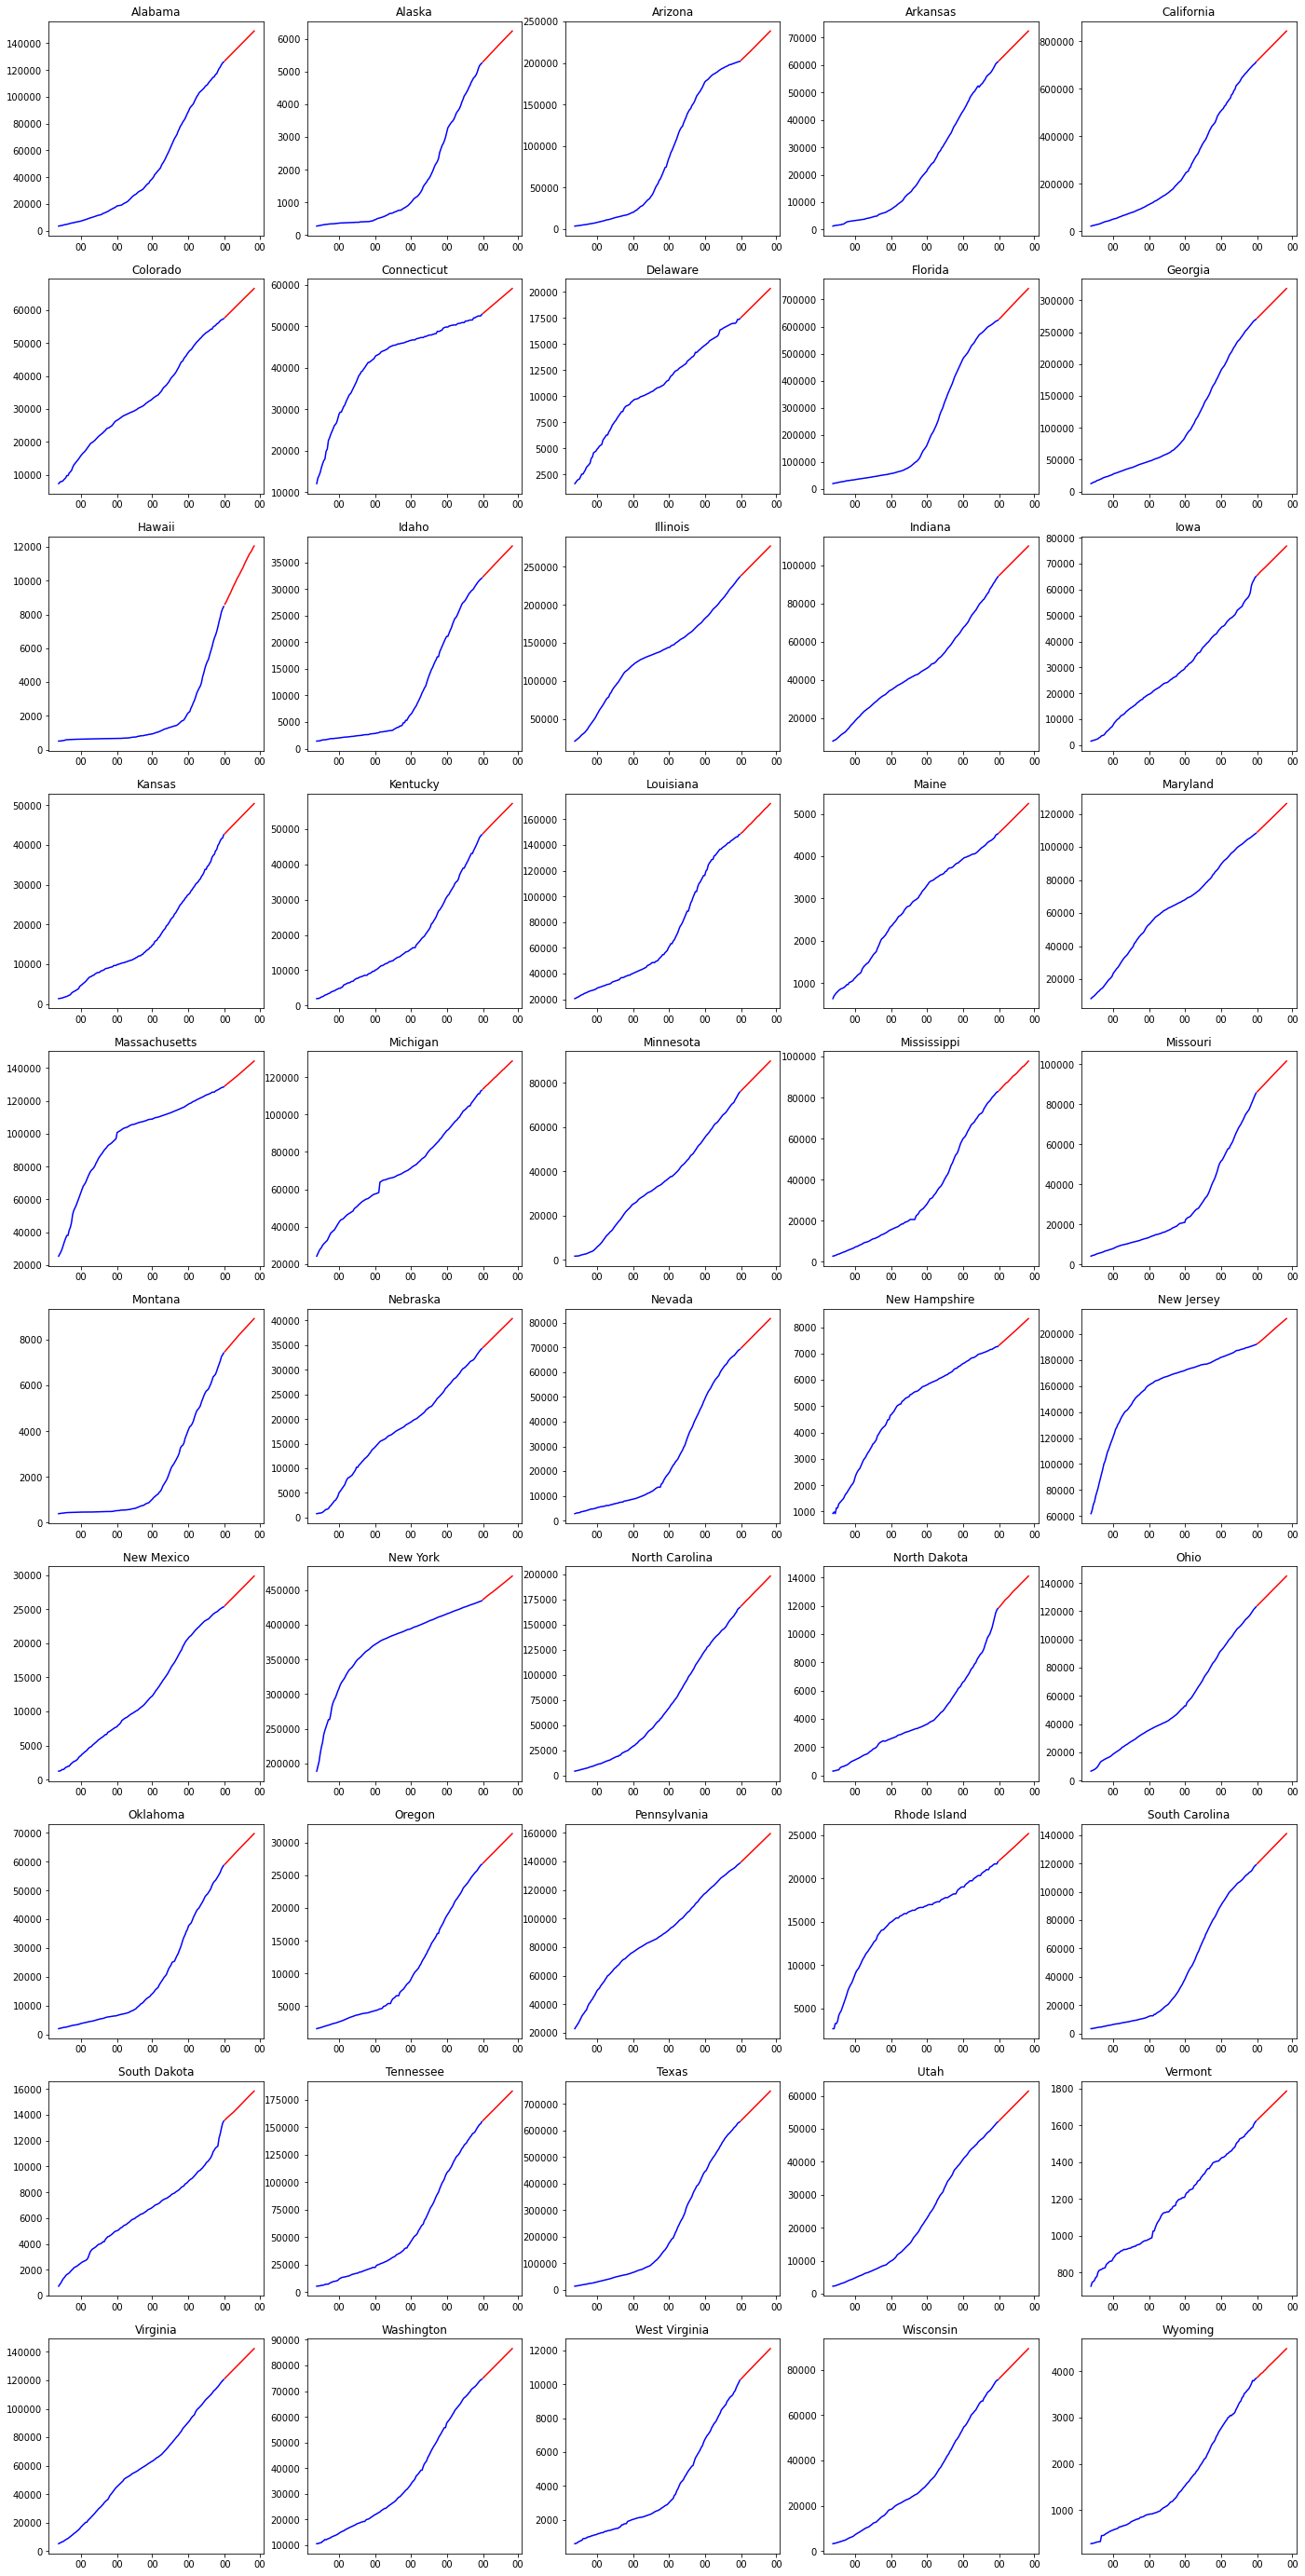

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (24, 50)

fig, ax = plt.subplots(nrows=10, ncols=5)

i = 0
for row in ax:
    for col in row:
        state = states[i]
        i += 1

        data = state_dfs_raw[state]['Confirmed'].copy()
        data.index = state_dfs[state].index
        fc = cleaned_dfs[state]['Confirmed']
        df = pd.DataFrame()
        df['y'] = data
        df = df.merge(fc, how='outer', left_index=True, right_index=True)

        col.set_title(state)
        col.xaxis.set_major_locator(mpl.dates.MonthLocator())
        col.xaxis.set_major_formatter(mpl.dates.DateFormatter('%M'))
        col.plot(df.index, df['y'], color='blue')
        col.plot(df.index, df['Confirmed'], color='red')

plt.show()

In [9]:
state = 'Alabama'
pd.concat([state_dfs[state], state_forecasts[state]]).plot()

In [10]:
state_dfs['Alabama'].iloc[-lag_order:]

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
Date,,,,,,,,,,
2020-08-17,1.598754,1.553496,1.211104,1.687652,1.599788,1.527922,1.795733,-1.166849,1.529769,0.441263
2020-08-18,1.633250,1.571537,1.211104,1.745440,1.634345,1.580777,1.795733,-1.180571,1.582783,0.367837
2020-08-19,1.661645,1.584658,1.211104,1.793052,1.662790,1.639666,1.822707,-1.192720,1.641850,0.363713
2020-08-20,1.686328,1.633861,1.443714,1.697741,1.687517,1.679070,1.877982,-1.179146,1.681372,0.424498
2020-08-21,1.716401,1.669943,1.443714,1.747586,1.717642,1.680176,1.877982,-1.177879,1.682482,0.362504
2020-08-22,1.739279,1.694544,1.443714,1.785582,1.740561,1.746286,1.916010,-1.178704,1.748791,0.391637
2020-08-23,1.752701,1.697825,1.443714,1.808165,1.754007,1.764852,1.916010,-1.186085,1.767413,0.364462
2020-08-24,1.794645,1.715866,1.443714,1.878532,1.796025,1.770539,1.980350,-1.203967,1.773117,0.406374
2020-08-25,1.808169,1.737187,1.443714,1.900814,1.809573,1.784180,1.980350,-1.200207,1.786799,0.379435


In [11]:
state_forecasts['Alabama']

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
2020-09-01,2.054847,2.000055,1.708726,2.151330,2.060074,2.009861,NaN,-1.222141,2.013075,NaN
2020-09-02,2.077152,2.025189,1.741485,2.171454,2.086158,2.035467,NaN,-1.238136,2.038663,NaN
2020-09-03,2.099843,2.051652,1.772010,2.194989,2.112139,2.061206,NaN,-1.249242,2.064390,NaN
2020-09-04,2.122008,2.078697,1.784491,2.222926,2.138079,2.086822,NaN,-1.258135,2.089998,NaN
2020-09-05,2.144824,2.105648,1.767927,2.256502,2.163994,2.111954,NaN,-1.268012,2.115091,NaN
2020-09-06,2.167185,2.131494,1.780301,2.286747,2.189789,2.137287,NaN,-1.279916,2.140400,NaN
2020-09-07,2.189478,2.156903,1.785947,2.313051,2.215653,2.162390,NaN,-1.294467,2.165519,NaN
2020-09-08,2.212379,2.182365,1.801787,2.336470,2.241596,2.187627,NaN,-1.311004,2.190763,NaN
2020-09-09,2.234624,2.207881,1.821812,2.361025,2.267384,2.212865,NaN,-1.328542,2.215997,NaN
2020-09-10,2.257272,2.233944,1.841361,2.386135,2.293313,2.238314,NaN,-1.343780,2.241427,NaN


In [12]:
state_dfs_raw['Alabama']['Confirmed'].plot()

In [13]:
cleaned_dfs['Alabama']['Confirmed'].plot()

In [14]:
state_forecasts['Alabama']['Deaths'].plot()

In [15]:
state_dfs_raw['Alabama']['Confirmed']

0         3563
50        3734
100       3953
150       4075
200       4345
         ...  
6850    121023
6900    122185
6950    123889
7000    125235
7050    126058
Name: Confirmed, Length: 142, dtype: int64

In [16]:
cleaned_dfs['Alabama']['Confirmed'].plot() # state_stds['Alabama']['Confirmed']